In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as stat
import networkx as nx
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from glob import glob
from data_parsing import load_trajectories

In [2]:
trajectories = load_trajectories('data/MITxPRO+AMxB+1T2018/edges')

In [3]:
# meta data includes the course title, run dates
AM_meta = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-meta.csv')
AM_meta

,id,metadata.display_name,category,metadata.start,metadata.end,metadata.enrollment_start,metadata.enrollment_end
0,MITxPRO+AMxB+1T2018,Additive Manufacturing for Innovative Design a...,course,2018-04-30 04:00:00,2018-07-02 23:30:00,2018-03-06,2018-05-11 23:30:00


In [4]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')

In [5]:
# session level edge data
AM_edges_sessionLevel01 = pd.read_csv('data/MITxPRO+AMxB+1T2018/edges/MITxPRO+AMxB+1T2018-stdAgg-edgeList-sessionLevel-1.csv')
#AM_edges_sessionLevel01[AM_edges_sessionLevel01['user_id'] == 15779327][100:150

3483

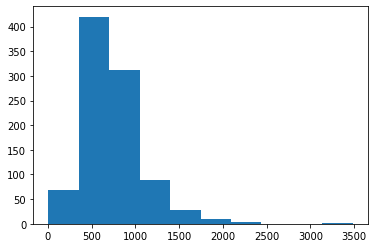

In [6]:
# # for each student this is list of numerical id's for the URLs - removing duplicates
# def get_trajectory(df):
#     order = [0]
#     for url in df['order']:
#         if url != order[-1]:
#             order.append(url)
#     order.append(0)
#     return order

# trajectories = []

# for fname in glob('data/MITxPRO+AMxB+1T2018/edges/*.csv'):
#     df = pd.read_csv(fname)
#     trajectories.append(df)
    
# trajectories = pd.concat(trajectories)
# trajectories = trajectories.groupby('user_id').apply(get_trajectory)
traj_lengths = trajectories.map(len).values

plt.hist(traj_lengths)
max(traj_lengths)
#trajectories[:25]

In [7]:
incoming_traj = []
outgoing_traj = []
n_train = 800
n_valid = 130

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)
    
def train_generator():
    while True:
        for i in range(0, n_train):
            x = incoming_traj[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield x,y
            
def valid_generator():
    while True:
        for i in range(n_train, n_train+n_valid):
            x = incoming_traj[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield x,y

In [8]:
hidden_dim = 30
embedding_dim = 30
number_of_URL = 1121
optimizer = Adam(learning_rate=0.0001)

input_ = Input(shape=(None,))
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model = Model(inputs=input_, outputs=predicted_URL)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          33630     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 30)          7320      
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 1121)        34751     
Total params: 75,701
Trainable params: 75,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
incoming_traj = []
outgoing_traj = []
n_train = 800
n_valid = 130

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

#add data for pass/fail to status
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
status = np.where(AM_id_and_performance['certGrp']=='Certified (< 70% Grade)', 1, 0)
#status = np.where(AM_id_and_performance['certGrp']=='Certified (< 70% Grade)')
    
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)
    
def train_generator2():
    while True:
        for i in range(0, n_train):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            #s = status[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield [x,s],y
            
def valid_generator2():
    while True:
        for i in range(n_train, n_train+n_valid):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            #status[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield [x,s],y

In [ ]:
hidden_dim = 30
embedding_dim = 30
number_of_URL = 1121
optimizer = Adam(learning_rate=0.0001)

input_x = Input(shape=(None,))
input_s = Input(shape=(None,))
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model2 = Model(inputs=[input_x, input_s], outputs=predicted_URL)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model2.summary()

In [ ]:
#model.save_weights('weights_version01.h5')

In [ ]:
model.load_weights('hid_dim30_w-improvement-96-1.72.hdf5', by_name=True)
filepath="hid_dim30_Lrate_0001_w-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit_generator(train_generator(), 
                    validation_data=valid_generator(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=500,
                    verbose=1,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 800 steps, validate for 130 steps
Epoch 1/500
799/800 [============================>.] - ETA: 0s - loss: 2.5862 - acc: 0.5909
Epoch 00001: val_loss improved from inf to 2.46878, saving model to hid_dim30_Lrate_0001_w-improvement-01-2.47.hdf5
800/800 [==============================] - 291s 363ms/step - loss: 2.5864 - acc: 0.5907 - val_loss: 2.4688 - val_acc: 0.5702
Epoch 2/500
799/800 [============================>.] - ETA: 0s - loss: 2.2173 - acc: 0.5905
Epoch 00002: val_loss improved from 2.46878 to 2.24440, saving model to hid_dim30_Lrate_0001_w-improvement-02-2.24.hdf5
800/800 [==============================] - 269s 337ms/step - loss: 2.2178 - acc: 0.5904 - val_loss: 2.2444 - val_acc: 0.5703
Epoch 3/500
799/800 [============================>.] - ETA: 0s - loss: 2.0413 - acc: 0.5909
Epoch 00003: val_loss improved from 2.24440 to 2.11284, saving model

In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
proposed_traj = [0]
while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    #s = np.zeros(x.shape)
    #predicted = np.argmax(model2.predict([x,s])[0,-1])
    predicted = np.argmax(model.predict(x)[0,-1])
    #print(predicted)
    proposed_traj.append(predicted)
print(proposed_traj)

# cert_traj = pd.DataFrame(proposed_traj)
# cert_traj.to_csv('common_NOcert_traj_hid_dim30.csv', header = ['Non-certified trajectory'], index = False)

In [ ]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]